STAT 479: Deep Learning (Spring 2019)  
Instructor: Sebastian Raschka (sraschka@wisc.edu)  
Course website: http://pages.stat.wisc.edu/~sraschka/teaching/stat479-ss2019/  
GitHub repository: https://github.com/rasbt/stat479-deep-learning-ss19

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p torch

Sebastian Raschka 

CPython 3.6.8
IPython 7.2.0

torch 1.0.0


- Runs on CPU or GPU (if available)

# Softmax Regression

Implementation of *classic* softmax regression.

## Imports

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn.functional as F

## Preparing a dataset

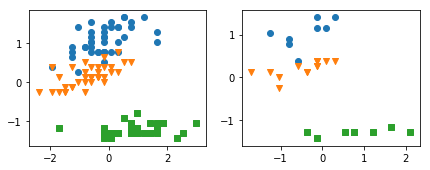

In [3]:
##########################
### DATASET
##########################



df = pd.read_csv('./data/iris.data', index_col=None, header=None)
df.columns = ['x1', 'x2', 'x3', 'x4', 'y']

d = {'Iris-versicolor': 1,
     'Iris-virginica': 2,
     'Iris-setosa': 0,
}

df['y'] = df['y'].map(d)

# Assign features and target

X = torch.tensor(df[['x2', 'x4']].values, dtype=torch.float)
y = torch.tensor(df['y'].values, dtype=torch.int)

# Shuffling & train/test split

torch.manual_seed(123)
shuffle_idx = torch.randperm(y.size(0), dtype=torch.long)

X, y = X[shuffle_idx], y[shuffle_idx]

percent80 = int(shuffle_idx.size(0)*0.8)

X_train, X_test = X[shuffle_idx[:percent80]], X[shuffle_idx[percent80:]]
y_train, y_test = y[shuffle_idx[:percent80]], y[shuffle_idx[percent80:]]

# Normalize (mean zero, unit variance)

mu, sigma = X_train.mean(dim=0), X_train.std(dim=0)
X_train = (X_train - mu) / sigma
X_test = (X_test - mu) / sigma


fig, ax = plt.subplots(1, 2, figsize=(7, 2.5))
ax[0].scatter(X_train[y_train == 2, 0], X_train[y_train == 2, 1])
ax[0].scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], marker='v')
ax[0].scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], marker='s')
ax[1].scatter(X_test[y_test == 2, 0], X_test[y_test == 2, 1])
ax[1].scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], marker='v')
ax[1].scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1], marker='s')
plt.show()

## Low-level implementation with manual gradients

In [4]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
def to_onehot(y, num_classes):
    y_onehot = torch.FloatTensor(y.size(0), num_classes)
    y_onehot.zero_()
    y_cpu = y.to(torch.device('cpu'))
    y_onehot.scatter_(1, y_cpu.view(-1, 1).long(), 1).float()
    return y_onehot.to(DEVICE)

def softmax(z):
    return (torch.exp(z.t()) / torch.sum(torch.exp(z), dim=1)).t()
                    
def cross_entropy(softmax, y_target):
    return -torch.sum(torch.log(softmax) * (y_target), dim=1)

In [6]:
def custom_where(cond, x_1, x_2):
    return (cond * x_1) + ((1-cond) * x_2)


class SoftmaxRegression1():
    def __init__(self, num_features, num_classes):
        self.num_features = num_features
        self.num_classes = num_classes
        self.weights = torch.zeros(num_classes, num_features, 
                                   dtype=torch.float32, device=DEVICE)
        self.bias = torch.zeros(num_classes, dtype=torch.float32, device=DEVICE)

    def forward(self, x):
        logits = torch.add(torch.mm(x, self.weights.t()), self.bias)
        probas = softmax(logits)
        return logits, probas
        
    def backward(self, x, y, probas):  
        grad_loss_out = y - probas # 120 x 3 dimensional
        grad_loss_w = -torch.mm(x.t(), grad_loss_out).t()
        grad_loss_b = -torch.sum(grad_loss_out)
        return grad_loss_w, grad_loss_b
            
    def predict_labels(self, x):
        logits, probas = self.forward(x)
        labels = torch.argmax(probas, dim=1)
        return labels    
            
    def evaluate(self, x, y):
        labels = self.predict_labels(x).float()
        accuracy = torch.sum(labels.view(-1) == y.float()).item() / y.size(0)
        return accuracy
    
    def train(self, x, y, num_epochs, learning_rate=0.01):
        epoch_cost = []
        for e in range(num_epochs):
            
            y_onehot = to_onehot(y, num_classes=self.num_classes)
            
            #### Compute outputs ####
            logits, probas = self.forward(x)
            
            #### Compute gradients ####
            grad_w, grad_b = self.backward(x, y_onehot, probas)

            #### Update weights ####
            self.weights -= learning_rate * grad_w / y.size(0)
            self.bias -= learning_rate * grad_b / y.size(0)
            
            #### Logging ####
            logits, probas = self.forward(x)
            cost = torch.mean(cross_entropy(probas, y_onehot))
            print('Epoch: %03d' % (e+1), end="")
            print(' | Train ACC: %.3f' % self.evaluate(x, y), end="")
            print(' | Cost: %.3f' % cost)
            epoch_cost.append(cost)
        return epoch_cost

In [7]:
X_train = X_train.to(DEVICE)
y_train = y_train.to(DEVICE)

model1 = SoftmaxRegression1(num_features=2, num_classes=3)
epoch_cost = model1.train(X_train, y_train, 
                          num_epochs=50,
                          learning_rate=0.1)

print('\nModel parameters:')
print('  Weights: %s' % model1.weights)
print('  Bias: %s' % model1.bias)

Epoch: 001 | Train ACC: 0.867 | Cost: 1.055
Epoch: 002 | Train ACC: 0.867 | Cost: 1.016
Epoch: 003 | Train ACC: 0.867 | Cost: 0.979
Epoch: 004 | Train ACC: 0.858 | Cost: 0.945
Epoch: 005 | Train ACC: 0.858 | Cost: 0.914
Epoch: 006 | Train ACC: 0.858 | Cost: 0.886
Epoch: 007 | Train ACC: 0.858 | Cost: 0.859
Epoch: 008 | Train ACC: 0.858 | Cost: 0.835
Epoch: 009 | Train ACC: 0.858 | Cost: 0.812
Epoch: 010 | Train ACC: 0.858 | Cost: 0.791
Epoch: 011 | Train ACC: 0.858 | Cost: 0.772
Epoch: 012 | Train ACC: 0.858 | Cost: 0.754
Epoch: 013 | Train ACC: 0.858 | Cost: 0.737
Epoch: 014 | Train ACC: 0.858 | Cost: 0.722
Epoch: 015 | Train ACC: 0.858 | Cost: 0.707
Epoch: 016 | Train ACC: 0.858 | Cost: 0.693
Epoch: 017 | Train ACC: 0.858 | Cost: 0.680
Epoch: 018 | Train ACC: 0.858 | Cost: 0.668
Epoch: 019 | Train ACC: 0.858 | Cost: 0.657
Epoch: 020 | Train ACC: 0.858 | Cost: 0.646
Epoch: 021 | Train ACC: 0.858 | Cost: 0.636
Epoch: 022 | Train ACC: 0.858 | Cost: 0.627
Epoch: 023 | Train ACC: 0.858 | 

#### Evaluating the Model

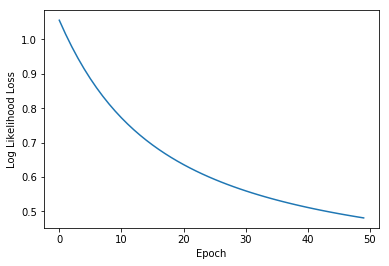

In [8]:
plt.plot(epoch_cost)
plt.ylabel('Log Likelihood Loss')
plt.xlabel('Epoch')
plt.show()

In [9]:
X_test = X_test.to(DEVICE)
y_test = y_test.to(DEVICE)

test_acc = model1.evaluate(X_test, y_test)
print('Test set accuracy: %.2f%%' % (test_acc*100))

Test set accuracy: 80.00%


## High-level implementation using the nn.Module API

In [10]:
class SoftmaxRegression2(torch.nn.Module):

    def __init__(self, num_features, num_classes):
        super(SoftmaxRegression2, self).__init__()
        self.linear = torch.nn.Linear(num_features, num_classes)
        # initialize weights to zeros here,
        # since we used zero weights in the
        # manual approach
        
        self.linear.weight.detach().zero_()
        self.linear.bias.detach().zero_()
        # Note: the trailing underscore
        # means "in-place operation" in the context
        # of PyTorch
        
    def forward(self, x):
        logits = self.linear(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas

model2 = SoftmaxRegression2(num_features=2, num_classes=3).to(DEVICE)
optimizer = torch.optim.SGD(model2.parameters(), lr=0.1)

In [11]:
def comp_accuracy(true_labels, pred_labels):
    accuracy = torch.sum(true_labels.view(-1).float() == 
                         pred_labels.float()).item() / true_labels.size(0)
    return accuracy



X_train = X_train.to(DEVICE)
y_train = y_train.to(DEVICE)
X_test = X_test.to(DEVICE)
y_test = y_test.to(DEVICE)

num_epochs = 50
for epoch in range(num_epochs):
    
    #### Compute outputs ####
    logits, probas = model2(X_train)
    
    #### Compute gradients ####
    cost = F.cross_entropy(logits, y_train.long())
    optimizer.zero_grad()
    cost.backward()
    
    #### Update weights ####  
    optimizer.step()
    
    #### Logging ####      
    logits, probas = model2(X_train)
    acc = comp_accuracy(y_train, torch.argmax(probas, dim=1))
    print('Epoch: %03d' % (epoch + 1), end="")
    print(' | Train ACC: %.3f' % acc, end="")
    print(' | Cost: %.3f' % F.cross_entropy(logits, y_train.long()))


    
print('\nModel parameters:')
print('  Weights: %s' % model2.linear.weight)
print('  Bias: %s' % model2.linear.bias)

Epoch: 001 | Train ACC: 0.833 | Cost: 1.055
Epoch: 002 | Train ACC: 0.833 | Cost: 1.015
Epoch: 003 | Train ACC: 0.833 | Cost: 0.979
Epoch: 004 | Train ACC: 0.833 | Cost: 0.945
Epoch: 005 | Train ACC: 0.833 | Cost: 0.914
Epoch: 006 | Train ACC: 0.833 | Cost: 0.885
Epoch: 007 | Train ACC: 0.833 | Cost: 0.859
Epoch: 008 | Train ACC: 0.833 | Cost: 0.835
Epoch: 009 | Train ACC: 0.833 | Cost: 0.812
Epoch: 010 | Train ACC: 0.833 | Cost: 0.791
Epoch: 011 | Train ACC: 0.833 | Cost: 0.772
Epoch: 012 | Train ACC: 0.833 | Cost: 0.754
Epoch: 013 | Train ACC: 0.833 | Cost: 0.737
Epoch: 014 | Train ACC: 0.833 | Cost: 0.722
Epoch: 015 | Train ACC: 0.833 | Cost: 0.707
Epoch: 016 | Train ACC: 0.833 | Cost: 0.693
Epoch: 017 | Train ACC: 0.833 | Cost: 0.680
Epoch: 018 | Train ACC: 0.833 | Cost: 0.668
Epoch: 019 | Train ACC: 0.833 | Cost: 0.657
Epoch: 020 | Train ACC: 0.833 | Cost: 0.646
Epoch: 021 | Train ACC: 0.842 | Cost: 0.636
Epoch: 022 | Train ACC: 0.867 | Cost: 0.627
Epoch: 023 | Train ACC: 0.867 | 

In [12]:
X_test = X_test.to(DEVICE)
y_test = y_test.to(DEVICE)

test_acc = model1.evaluate(X_test, y_test)
print('Test set accuracy: %.2f%%' % (test_acc*100))

Test set accuracy: 80.00%
